# Comparing movie streaming platforms

In this notebook, I will compare four major movie streming platforms, Netflix, Amazon Prime Video, Hulu, and Disney+, in terms of how many movies I would like to watch they have. To create my list of preferred movies, I will scrape the movies according to two criteria:

1. The movies that participated in the main competitions of the three most prestigious film festivals: Venice, Cannes, and Berlin.
2. The movies that have a Metacritic score of no less than 75.

In both cases, I will collect only those movies that were release between 2000 and 2021.

To get the information about the movies availbale on the the four streaming platforms, I will use the datasets created by Shivam Bansal that are available of [Kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows).

I will then compare the two lists to get the data about how many movies from my list are available on each of the platforms.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': (9, 6)})

In [2]:
# taken from here - https://stackoverflow.com/a/42240682/16772424

headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
}

I will start by scraping the movies that participated in main competitions in Venice, Cannes, and Berlin film festivals from 2000-2021. I will then scrape the highest-rated movies according to Metacritic. Finally, I will concatenate both dataframes to create my watchlist.

In [3]:
# function for getting data from a Wikipedia list

def parse_competition_list(competition_list):
    
    titles = []
    directors = []
    
    movies = competition_list.find_all('li')
    
    for movie in movies:
            
        full_text = movie.text
            
        if movie.find('i') is not None:
            title = movie.find('i').text.strip()
        else:
            title = re.search('(.*)(?= by)', full_text)[0]
                
        titles.append(title)
            
        try:
            director = re.search('(?<=by )(.*)', full_text)[0]
            directors.append(director)
        except:
            directors.append(np.nan)
            
    return titles, directors

In [4]:
# function for getting data from a Wikipedia table

def parse_competition_table(competition_table):
    
    titles = []
    directors = []
    
    movies = competition_table.find_all('tr')[1:]
    
    for movie in movies:
        
        if movie.find('td') is not None:
            
            if movie.find('td').find('i') is not None:
                title = movie.find('td').find('i').text.strip()
            else:
                continue
        
        else:
            continue
        
        titles.append(title)
        
        if len(movie.find_all('td')) == 4:
            director = movie.find_all('td')[2].text.strip()
            
        else:
            try:
                director = movie.find_all('td')[1].text.strip()
            except:
                director = np.nan
            
        directors.append(director)
        
    return titles, directors

In [5]:
# function for getting the link for a festival in a given year

def get_festival_url(festival, year):
    
    url = f'https://en.wikipedia.org/wiki/{year}_{festival}_Film_Festival'
    
    return url

In [6]:
# function for getting data about festival movies

def get_festival_movies(festival, year):
    
    url = get_festival_url(festival, year)
    html_doc = requests.get(url).text
    soup = BeautifulSoup(html_doc, 'html.parser')
    
    all_titles = []
    all_directors = []
    
    tables_classes = ['sortable wikitable', 'wikitable sortable', 'wikitable']
    
    if (festival == 'Cannes') & (year <= 2002):
        
        competition_list = soup.find('div', {'class': "div-col", 'style': "column-width: 30em;"})
        titles, directors = parse_competition_list(competition_list)
        all_titles.extend(titles)
        all_directors.extend(directors)
        
    elif (festival == 'Cannes') & (year == 2020):
        
        pass
        
    else:
        
        competition_table = soup.find('table', {'class': tables_classes})
        titles, directors = parse_competition_table(competition_table)
        all_titles.extend(titles)
        all_directors.extend(directors)
        
    movies_dict = {'title': all_titles, 'director': all_directors, 'year': year}
    
    return movies_dict

In [7]:
# function for getting movie director from Metacritic move page

def get_movie_director(movie_link):
    
    html_doc = requests.get(movie_link, headers=headers).text
    soup = BeautifulSoup(html_doc, 'html.parser')
    
    if soup.find('div', {'class': 'director'}) is not None:
        director_tags = soup.find('div', {'class': 'director'})
    else:
        director_tags = soup.find('div', {
            'class': 'c-crewList g-inner-spacing-bottom-small c-entertainmentProductDetails_staff_directors'
        })
        
    if director_tags is not None:
    
        all_directors = director_tags.find_all('a')
        
        if len(all_directors) == 1:
            director = all_directors[0].text.strip()
        else:
            director = ''
            for directors_part in all_directors:
                director += directors_part.text.strip() + ', '
        
        director = director.rstrip(', ')
        
    else:
        director = np.nan
                
    return director

In [8]:
# function for getting the data about top-rated Metacritic movies

def get_metacritic_movies(year):
    
    titles = []
    scores = []
    directors = []
    
    for page in range(0, 2):
    
        url = f'https://www.metacritic.com/browse/movies/score/metascore/year/filtered?year_selected={year}&page={page}'
        html_doc = requests.get(url, headers=headers).text
        soup = BeautifulSoup(html_doc, 'html.parser')

        title_tags = soup.find_all('a', {'class': 'title'})
        
        score_tags_duplicated = soup.find_all('div', {'class': 'metascore_w large movie positive'})
        score_tags = score_tags_duplicated[::2]
                
        for title_tag, score_tag in zip(title_tags, score_tags):

            title = title_tag.text.strip()
            score = int(score_tag.text.strip())
            
            movie_link = 'https://www.metacritic.com' + title_tag['href']
            director = get_movie_director(movie_link)

            if score < 75:
                break

            titles.append(title)
            scores.append(score)
            directors.append(director)
            
    movies_dict = {'title': titles, 'director': directors, 'score': scores, 'year': year}
    
    return movies_dict

In [9]:
# function for creating a dataframe with the festival movie data

def create_festival_movies_df(festival):

    movies_list = []

    for year in range(2000, 2022):

        movies = get_festival_movies(festival, year)
        movies_list.append(movies)

    movies_df = pd.DataFrame(movies_list).explode(['title', 'director']).reset_index(drop=True)
    movies_df['festival'] = festival
    
    return movies_df

In [10]:
# function for creating a dataframe with the Metacritic movie data

def create_metacritic_movies_df():

    movies_list = []

    for year in range(2000, 2022):

        movies = get_metacritic_movies(year)
        movies_list.append(movies)

    movies_df = pd.DataFrame(movies_list).explode(['title', 'director', 'score']).reset_index(drop=True) 
    
    return movies_df

In [11]:
cannes_movies = create_festival_movies_df('Cannes')
cannes_movies.dropna(inplace=True)
berlin_movies = create_festival_movies_df('Berlin')
venice_movies = create_festival_movies_df('Venice')
festival_movies = pd.concat([cannes_movies, berlin_movies, venice_movies], ignore_index = True)
festival_movies['movie_type'] = 'Festival movies'

metacritic_movies = create_metacritic_movies_df()
metacritic_movies['movie_type'] = 'Metacritic movies'
my_movies = pd.concat([festival_movies, metacritic_movies], ignore_index = True)
my_movies.director.fillna('None', inplace=True)

In [12]:
titles_translations = {
    'Code inconnu: Récit incomplet de divers voyages': 'Code Unknown',
    'Guizi lai le': 'Devils on the Doorstep',
    'Harry, un ami qui vous veut du bien': "Harry, He's Here to Help",
    'Les destinées sentimentales': 'Sentimental Destinies',
    'Svadba': 'The Wedding',
    'Sånger från andra våningen': 'Songs from the Second Floor',
    'Takhté siah': 'Blackboards',
    'Trolösa': 'Faithless',
    'Yurîka': 'Eureka'
}

my_movies.title = my_movies.title.replace(titles_translations)
my_movies.drop_duplicates(['title', 'director'], inplace=True)
no_my_movies = len(my_movies)
print(f'There are {no_my_movies} movies on my watchlist')

There are 3096 movies on my watchlist


Let's look at the directors with the biggest number of movies on my watchlist.

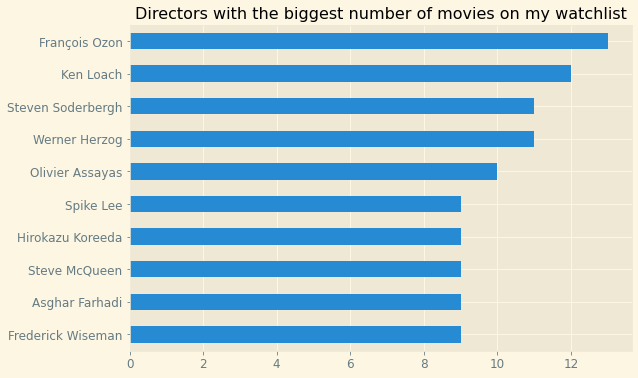

In [13]:
ax1 = my_movies.director.value_counts().head(10).plot.barh()
ax1.invert_yaxis()
plt.title('Directors with the biggest number of movies on my watchlist')
plt.savefig('fig1.png', bbox_inches='tight')
plt.show()

Next, I will load the datasets from Kaggle that have information about movies available on [Netflix](https://www.kaggle.com/datasets/shivamb/netflix-shows), [Amazon Prime Video](https://www.kaggle.com/datasets/shivamb/amazon-prime-movies-and-tv-shows), [Hulu](https://www.kaggle.com/datasets/shivamb/hulu-movies-and-tv-shows), and [Disney+](https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows) and combine them as well.

In [14]:
netflix_movies = pd.read_csv('data/netflix_titles.csv')
amazon_movies = pd.read_csv('data/amazon_prime_titles.csv')
hulu_movies = pd.read_csv('data/hulu_titles.csv')
disney_movies = pd.read_csv('data/disney_plus_titles.csv')

netflix_movies['streaming_platform'] = 'Netflix'
amazon_movies['streaming_platform'] = 'Amazon Prime'
hulu_movies['streaming_platform'] = 'Hulu'
disney_movies['streaming_platform'] = 'Disney+'

cols_to_keep = ['title', 'director', 'year', 'streaming_platform']

all_streaming_movies = pd.concat([netflix_movies, amazon_movies, hulu_movies, disney_movies], ignore_index=True)
streaming_movies_full = all_streaming_movies[all_streaming_movies.type == 'Movie'].reset_index(drop=True)
streaming_movies = streaming_movies_full.rename(columns={'release_year': 'year'})[cols_to_keep]

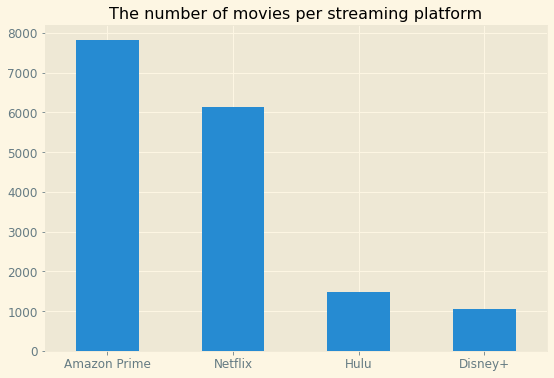

In [15]:
streaming_movies_per_platform = streaming_movies.groupby('streaming_platform').title.count().sort_values(ascending=False)
ax2 = streaming_movies_per_platform.plot.bar()
plt.xticks(rotation=0)
plt.title('The number of movies per streaming platform')
plt.xlabel('')
plt.savefig('fig3.png')
plt.show()

I will now merge the dataset with my watchlist and the dataset with the streaming platform movies on the combination of columns that represent a unique movies. Since the movies in Hulu dataset doesn't have the information about movie directors, I will merge the datasets on two possible combinations:

- title and director
- title and year

Finally, I will concatentae two resulting dataframes and drop entries with duplicate combination of title and streaming platform to keep only unique pairs of movies and streaming platforms. To get only the unique titles, I will create another dataframe by dropping entries with duplicate titles.

In [16]:
cols_to_keep_new = ['title', 'streaming_platform', 'movie_type']

merged_on_title_director = pd.merge(streaming_movies, my_movies, on=['title', 'director'], how='inner')[cols_to_keep_new]
merged_on_title_year = pd.merge(streaming_movies, my_movies, on=['title', 'year'], how='inner')[cols_to_keep_new]

In [17]:
merged_full = pd.concat([merged_on_title_director, merged_on_title_year]).drop_duplicates(['title', 'streaming_platform'])

In [18]:
movies_on_my_watchlist = merged_full.groupby('streaming_platform').title.count()

for platform, no_movies in movies_on_my_watchlist.iteritems():
    print(f'There are {no_movies} movies from my watchlist available on {platform}')    

There are 102 movies from my watchlist available on Amazon Prime
There are 33 movies from my watchlist available on Disney+
There are 118 movies from my watchlist available on Hulu
There are 280 movies from my watchlist available on Netflix


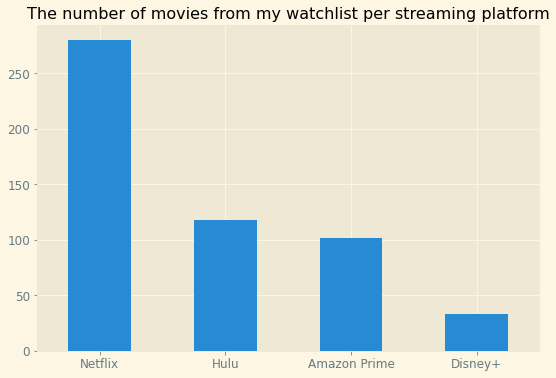

In [19]:
my_movies_per_platform = movies_on_my_watchlist.sort_values(ascending=False)
ax3 = my_movies_per_platform.plot.bar()
plt.xticks(rotation=0)
plt.title('The number of movies from my watchlist per streaming platform')
plt.xlabel('')
plt.savefig('fig4.png')
plt.show()

In [20]:
merged_unique = merged_full.drop_duplicates('title')
total_no_movies = len(merged_unique)
print(f'There are {total_no_movies} unique movies from my watchlist on all four platforms in total')

There are 506 unique movies from my watchlist on all four platforms in total
